# Draftsheet 

In [ ]:
from fastcore.all import *
import wandb
from plotnine import *
import pandas as pd
import numpy as np

### Get the validation errors of a classification learner, plot them in different ways and store the resulting images to be validated by an expert

In [ ]:
from PIL import Image  
import PIL
from fastcore.all import *

In [ ]:
def buffer_plot_and_get(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    return PIL.Image.open(buf)

In [ ]:
def get_concat_h_multi_resize(im_list, resample=PIL.Image.BICUBIC):
    min_height = min(im.height for im in im_list)
    im_list_resize = [im.resize((int(im.width * min_height / im.height), min_height),resample=resample)
                      for im in im_list]
    total_width = sum(im.width for im in im_list_resize)
    dst = PIL.Image.new('RGB', (total_width, min_height))
    pos_x = 0
    for im in im_list_resize:
        dst.paste(im, (pos_x, 0))
        pos_x += im.width
    return dst

In [ ]:
def get_multiview_at(ds, idx, ylim):
    "TODO: Move this to TensorMotion?"
    fig1 = show_at(ds, idx, return_fig=True, ylim=ylim)
    fig2 = show_at(ds, idx, return_fig=True)
    fig3 = show_at(ds, idx, mode='stacked', return_fig=True)
    pils = [buffer_plot_and_get(fig) for fig in [fig1, fig2, fig3]]
    return get_concat_h_multi_resize(pils)

In [ ]:
import pandas as pd

In [ ]:
def generate_classification_error_report(learn, folder, ylim):
    "Warning: Call this function with the %%capture magic, otherwise you will be \
    prompted with all the outputs from the calls to `show`. Requires xlrd to read xlsx \
    files."
    probs, targets, preds = learn.get_preds(with_decoded=True)
    error_valid_idxs = torch.where(targets!=preds, tensor(1), tensor(0)).nonzero().squeeze()
    error_ds_idxs = tensor(learn.dls.dataset.splits[1])[error_valid_idxs]
    for valid_idx, ds_idx in zip(error_valid_idxs, error_ds_idxs):
        merged_pil = get_multiview_at(learn.dls.valid.dataset, valid_idx, ylim)
        folder = Path(folder)
        merged_pil.save(f'{folder}/{ds_idx}.png')
    # Generate a csv file with the item indices and the targets
    preds_decoded = [str(ds.valid.tfms[1].decode(x)) for x in preds[error_valid_idxs]]
    targs_decoded = [str(ds.valid.tfms[1].decode(x)) for x in targets[error_valid_idxs]]
    rlbl_df = pd.DataFrame(list(zip(error_ds_idxs.numpy(), preds_decoded, targs_decoded)), 
                       columns=['Item #', 'ML classification', 'FLI-based classification'])
    rlbl_path = Path(f'{folder}/relabelling.xlsx')
    if rlbl_path.exists():
        # Load old relabelling and merge it with the new items
        rlbl_df_old = pd.read_excel(rlbl_path)
        rlbl_df = pd.concat([rlbl_df, rlbl_df_old]).drop_duplicates()
    rlbl_df = rlbl_df.sort_values(by=['Item #'])
    rlbl_df.to_excel(rlbl_path, index=False)

## Plot results from extrapolation experiment

In [ ]:
api = wandb.Api()

In [ ]:
sweep_paths = ["vrodriguezf90/mlchaos/sweeps/lwatcf28", 
               "vrodriguezf90/mlchaos/sweeps/29ewkxzx",
              "vrodriguezf90/mlchaos/sweeps/xzwgf028"]
#sweep_paths = ["vrodriguezf/mlchaos/sweeps/obkusmv0", 
#               "vrodriguezf/mlchaos/sweeps/zbm7b79g",
#              "vrodriguezf/mlchaos/sweeps/pybesik5"]
runs = L([api.sweep(path=o).runs for o in sweep_paths]).concat()
runs

(#120) [<Run vrodriguezf90/mlchaos/wrhnim2f (finished)>,<Run vrodriguezf90/mlchaos/k851eo79 (finished)>,<Run vrodriguezf90/mlchaos/428rajrb (finished)>,<Run vrodriguezf90/mlchaos/aczwuabl (finished)>,<Run vrodriguezf90/mlchaos/f991rqy5 (finished)>,<Run vrodriguezf90/mlchaos/vvgfkctr (finished)>,<Run vrodriguezf90/mlchaos/3vlv3aka (finished)>,<Run vrodriguezf90/mlchaos/zafh6do4 (finished)>,<Run vrodriguezf90/mlchaos/ju2armm4 (finished)>,<Run vrodriguezf90/mlchaos/grlv7llo (finished)>...]

In [ ]:
df = pd.DataFrame({
    'Trained_on': runs.map(lambda o: o.config['train_model']), 
    'Tested_on': runs.map(lambda o: o.config['test_model']),
    'Test_eps': runs.map(lambda o: o.config['test_eps']),
    'Accuracy': runs.map(lambda o: o.summary.get('test_acc'))
})
df

,Trained_on,Tested_on,Test_eps,Accuracy
0,model_1,model_3,eps=0.025,0.714752
1,model_1,model_2,eps=0.025,0.703605
2,model_1,model_3,eps=0.02,0.748422
3,model_1,model_2,eps=0.02,0.760404
4,model_1,model_3,eps=0.015,0.794905
...,...,...,...,...
115,model_3,model_1,eps=0.02,0.975341
116,model_3,model_2,eps=0.015,0.950388
117,model_3,model_1,eps=0.015,0.983410
118,model_3,model_2,eps=0.01,0.922177


In [ ]:
df['Trained_on'] = np.select(
    [
        df['Trained_on'] == 'model_1', 
        df['Trained_on'] == 'model_2', 
        df['Trained_on'] == 'model_3'
    ],
    ['H2', 'H3', 'H4']
)
df['Tested_on'] = np.select(
    [
        df['Tested_on'] == 'model_1', 
        df['Tested_on'] == 'model_2', 
        df['Tested_on'] == 'model_3'
    ],
    ['H2', 'H3', 'H4']
)

Filter runs that have None Accuracy

In [ ]:
df = df.query('Accuracy == Accuracy')
df

,Trained_on,Tested_on,Test_eps,Accuracy
0,H2,H4,eps=0.025,0.714752
1,H2,H3,eps=0.025,0.703605
2,H2,H4,eps=0.02,0.748422
3,H2,H3,eps=0.02,0.760404
4,H2,H4,eps=0.015,0.794905
...,...,...,...,...
115,H4,H2,eps=0.02,0.975341
116,H4,H3,eps=0.015,0.950388
117,H4,H2,eps=0.015,0.983410
118,H4,H3,eps=0.01,0.922177


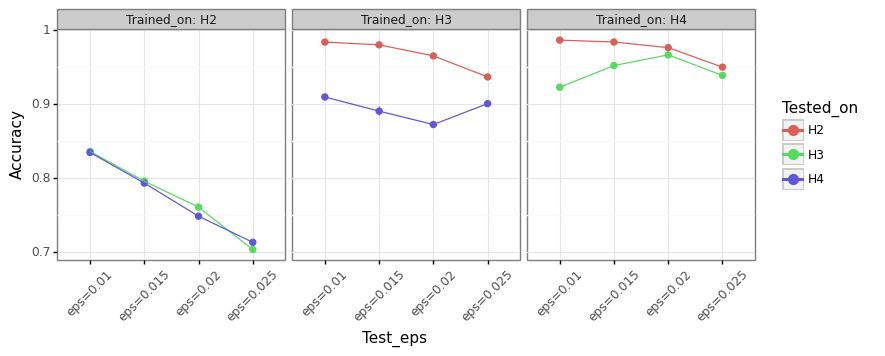

<ggplot: (8764719878774)>

In [ ]:
p = (
    ggplot(df, aes(x='Test_eps', y='Accuracy', color='Tested_on', group='Tested_on')) + 
    facet_wrap('~Trained_on', labeller='label_both') + 
    stat_summary(geom='geom_pointrange', shape='o') +
    stat_summary(geom='geom_line') + 
    theme_bw() +
    theme(axis_text_x=element_text(angle=45)) + 
    theme(figure_size=(9, 3))
)
p

In [ ]:
ggsave(p, "asd.eps")

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 3 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: asd.eps


### Plot accuracy vs points per motion

In [ ]:
df = pd.read_csv('../wandb_exports/wandb_export_2021-05-18T17_06_34.698+02_00.csv')

In [ ]:
df

,Name,input dim 2,_wandb,accuracy
0,solar-tree-180,2,NaN,0.753616
1,misty-butterfly-179,2,NaN,0.752755
2,charmed-sponge-178,2,NaN,0.750517
3,comic-serenity-177,2,NaN,0.831784
4,brisk-cloud-176,2,NaN,0.751722
...,...,...,...,...
145,floral-music-35,201,NaN,0.994835
146,helpful-pyramid-34,201,NaN,0.995351
147,gentle-wave-33,201,NaN,0.995007
148,dutiful-durian-32,201,NaN,0.995696


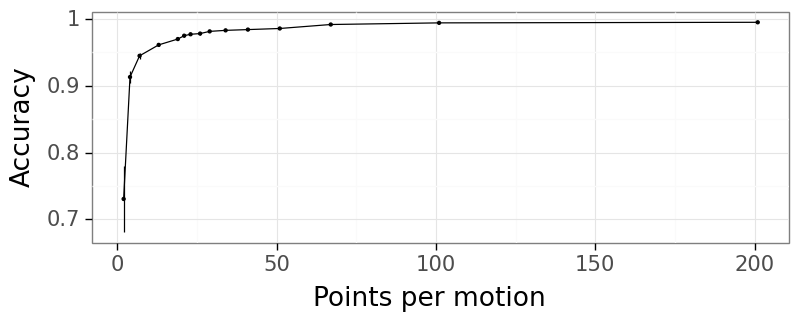

<ggplot: (8742381253726)>

In [ ]:
p = (
    ggplot(df, aes(x='input dim 2', y='accuracy', group=1)) + 
    stat_summary(geom='geom_pointrange', shape='.') +
    stat_summary(geom='geom_line') + 
    theme_bw(base_size=19) +
    xlab('Points per motion') +
    ylab('Accuracy') + 
    theme(figure_size=(9, 3))
)
p

In [ ]:
ggsave(p, "asd.eps")

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 3 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: asd.eps


### Spint orbit case: results

In [ ]:
api = wandb.Api()

In [ ]:
sweep_paths = ["vrodriguezf90/mlchaos/sweeps/zg79nm9t", "vrodriguezf90/mlchaos/sweeps/dntxgjwn"]
runs = L([api.sweep(path=o).runs for o in sweep_paths]).concat()
runs

(#50) [<Run vrodriguezf90/mlchaos/oc4ls0wm (finished)>,<Run vrodriguezf90/mlchaos/r1inu7wm (finished)>,<Run vrodriguezf90/mlchaos/ou0j6bar (finished)>,<Run vrodriguezf90/mlchaos/lbek8wf6 (finished)>,<Run vrodriguezf90/mlchaos/13bzxs51 (finished)>,<Run vrodriguezf90/mlchaos/3bpxz1cj (finished)>,<Run vrodriguezf90/mlchaos/vj760616 (finished)>,<Run vrodriguezf90/mlchaos/ko6s3gtr (finished)>,<Run vrodriguezf90/mlchaos/4o4vexl4 (finished)>,<Run vrodriguezf90/mlchaos/xl2o1mod (finished)>...]

In [ ]:
df = pd.DataFrame({
    'test_ecc': runs.map(lambda o: o.config['test_model']), 
    'Accuracy': runs.map(lambda o: o.summary.get('test_acc'))
})
df['Accuracy'] = df['Accuracy'].astype('float64')
df['test_ecc'] = df['test_ecc'].str[16:20]
df = df.dropna()
df.shape

(45, 2)

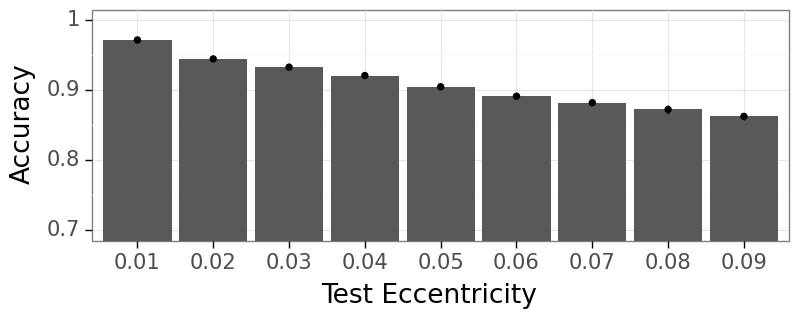

<ggplot: (8742381741864)>

In [ ]:
p = (
    ggplot(df, aes(x='test_ecc', y='Accuracy', group=1)) + 
    stat_summary(geom='geom_bar') + 
    stat_summary(geom='pointrange') +
    coord_cartesian(ylim=[0.7, 1]) + 
    xlab('Test Eccentricity') + 
    theme_bw(base_size=19) +
    theme(figure_size=(9, 3))
)
p

In [ ]:
ggsave(p, "asd.eps")

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 3 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: asd.eps


## Indexing method comparison

In [ ]:
api = wandb.Api()

In [ ]:
sweep_paths = ["vrodriguezf90/mlchaos/sweeps/1qg2e9i4"]
runs = L([api.sweep(path=o).runs for o in sweep_paths]).concat()
runs

(#25) [<Run vrodriguezf90/mlchaos/faj7ujgu (finished)>,<Run vrodriguezf90/mlchaos/fkptwpd1 (finished)>,<Run vrodriguezf90/mlchaos/au13qt77 (finished)>,<Run vrodriguezf90/mlchaos/4i8f6w98 (finished)>,<Run vrodriguezf90/mlchaos/yop0hb6r (finished)>,<Run vrodriguezf90/mlchaos/xaywdb32 (finished)>,<Run vrodriguezf90/mlchaos/bo6bwl8x (finished)>,<Run vrodriguezf90/mlchaos/zp9g2ynd (finished)>,<Run vrodriguezf90/mlchaos/kjjhp79j (finished)>,<Run vrodriguezf90/mlchaos/96e8ad4o (finished)>...]

In [ ]:
df = pd.DataFrame({
    'labelling_method': runs.map(lambda o: o.config['labelling_method']), 
    'accuracy': runs.map(lambda o: o.summary.get('accuracy'))
})
df.query('labelling_method == "fli" or \
         labelling_method == "freq_ana_eq_3.6" or labelling_method == "birav"', inplace=True)
df.replace(to_replace="fli", value="FLI", inplace=True)
df.replace(to_replace="fli_no_uncertainty", value="FLI no uncertainty", inplace=True)
df.replace(to_replace="freq_ana_eq_3.6", value="Monotonicity", inplace=True)
df.replace(to_replace="birav", value="Convergence", inplace=True)
df.shape

(15, 2)

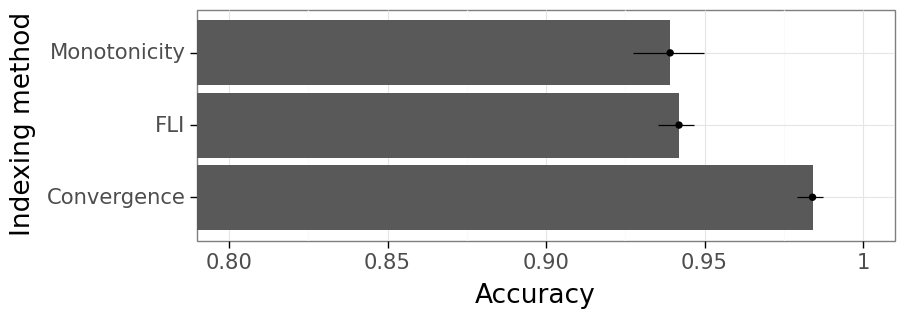

<ggplot: (8742381619640)>

In [ ]:
p = (
    ggplot(df, aes(x='labelling_method', y='accuracy', group=1)) + 
    stat_summary(geom='geom_bar') + 
    stat_summary(geom='pointrange') +
    xlab('Indexing method') + 
    ylab('Accuracy') + 
    coord_flip(ylim=[0.8, 1]) + 
    theme_bw(base_size=19) +
    theme(figure_size=(9, 3))
)
p

In [ ]:
ggsave(p, "asd.eps")

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 3 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: asd.eps


## Architecture comparison

In [ ]:
api = wandb.Api()

In [ ]:
sweep_paths = ["vrodriguezf90/mlchaos/sweeps/26vwf55g", "vrodriguezf90/mlchaos/sweeps/f5f09wsa"]
runs = L([api.sweep(path=o).runs for o in sweep_paths]).concat()
runs

(#20) [<Run vrodriguezf90/mlchaos/evovfqyj (finished)>,<Run vrodriguezf90/mlchaos/keegn41w (finished)>,<Run vrodriguezf90/mlchaos/2x4z83rx (finished)>,<Run vrodriguezf90/mlchaos/h34oz3z7 (finished)>,<Run vrodriguezf90/mlchaos/bxvj74d7 (finished)>,<Run vrodriguezf90/mlchaos/14ud9xta (finished)>,<Run vrodriguezf90/mlchaos/17sbp3r5 (finished)>,<Run vrodriguezf90/mlchaos/mxon9g8j (finished)>,<Run vrodriguezf90/mlchaos/2wfatm11 (finished)>,<Run vrodriguezf90/mlchaos/kpz3g7e1 (finished)>...]

In [ ]:
df = pd.DataFrame({
    'Architecture': runs.map(lambda o: o.config['arch_name']), 
    'Accuracy': runs.map(lambda o: o.summary.get('accuracy'))
})

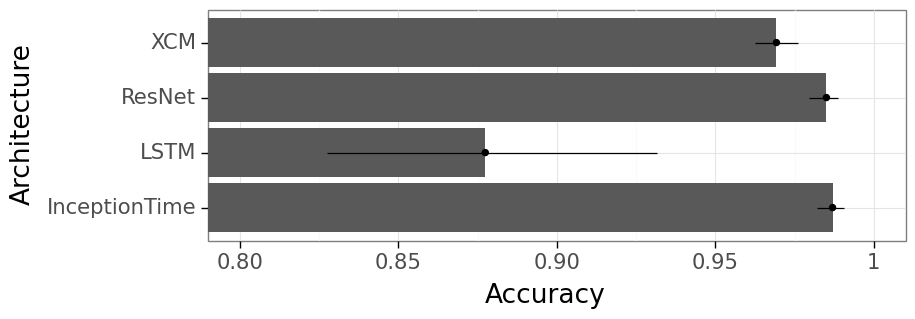

<ggplot: (8742381293969)>

In [ ]:
p = (
    ggplot(df, aes(x='Architecture', y='Accuracy', group=1)) + 
    stat_summary(geom='geom_bar') + 
    stat_summary(geom='pointrange') +
    coord_flip(ylim=[0.8, 1]) + 
    theme_bw(base_size=19) +
    theme(figure_size=(9, 3))
)
p

In [ ]:
ggsave(p, "asd.eps")

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 9 x 3 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: asd.eps


## Complete cartography, test accuracy

In [ ]:
N = 10197 # total number of data points in the cartography

In [ ]:
#Donwloaded from wandb table as a csv, then copy&paste the id column here
run_ids = """2dgn6lof
1t452v39
ktp7opwv
35ukxqjf
23c239ci
38x9x72i
26ihg10f
1io601nv
1x0usue9"""
run_ids = run_ids.splitlines()
run_ids

['2dgn6lof',
 '1t452v39',
 'ktp7opwv',
 '35ukxqjf',
 '23c239ci',
 '38x9x72i',
 '26ihg10f',
 '1io601nv',
 '1x0usue9']

In [ ]:
api = wandb.Api()
runs = L([api.run('vrodriguezf90/mlchaos/' + o) for o in run_ids])

In [ ]:
df = pd.DataFrame({
    'Reduction factor': runs.map(lambda o: np.ceil(N/o.config['nb_samples'])), 
    'Accuracy': runs.map(lambda o: o.summary.get('test_acc'))
})
df[:3]

,Reduction factor,Accuracy
0,10.0,0.063419
1,9.0,0.918910
2,8.0,0.921094


,Reduction factor,Accuracy
0,10.0,0.063419
1,9.0,0.918910
2,8.0,0.921094
3,7.0,0.923341
4,6.0,0.958103
5,5.0,0.956847
6,4.0,0.965215
7,3.0,0.984407
8,2.0,0.986269


/usr/local/lib/python3.8/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_summary : Removed 1 rows containing non-finite values.


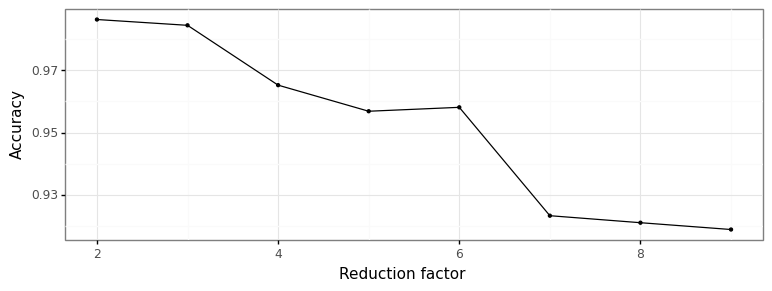

<ggplot: (8787048100084)>

In [ ]:
p = (
    ggplot(df, aes(x='Reduction factor', y='Accuracy', group=1)) + 
    stat_summary(geom='geom_pointrange', shape='.') +
    stat_summary(geom='geom_line') + 
    #coord_flip(ylim=[0.8, 1]) + 
    xlim(2, 9) + 
    theme_bw() +
    theme(figure_size=(9, 3))
)
p